## 1. Project Overview

### 1.1 Problem Statement

#### Project goal definition

#### Dataset background introduction

#### Expected outcomes

## 2. Data Preparation and Exploration

### 2.1 Data Loading and Initialization

#### Import necessary libraries

In [1]:
# Standard Library Imports
import gc
from pathlib import Path

# Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Advanced Machine Learning
import lightgbm as lgb
import optuna

In [2]:
raw_PUBG = pd.read_csv(Path('data') / 'PUBG.csv')

#### Memory optimization settings

In [3]:
raw_PUBG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [4]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [5]:
PUBG = reduce_mem_usage(raw_PUBG)
del raw_PUBG
gc.collect()
PUBG.info()

Memory usage of dataframe is 983.90 MB
Memory usage after optimization is: 339.28 MB
Decreased by 65.5%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float32
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float32
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float32
 21  roadKills        int8   
 22  swimDistance     float32
 23  teamKills        int8   
 24

#### Selective column import

In [6]:
PUBG = PUBG.drop(['Id', 'groupId', 'matchId', 'rankPoints', 'winPoints'], axis=1)

### 2.2 Exploratory Data Analysis (EDA)

#### Basic statistical analysis

In [7]:
print("Dataset Shape:", PUBG.shape)

Dataset Shape: (4446966, 24)


In [8]:
PUBG.head()

assists  boosts  damageDealt  DBNOs  headshotKills  heals  killPlace  \
0        0       0     0.000000      0              0      0         60   
1        0       0    91.470001      0              0      0         57   
2        1       0    68.000000      0              0      0         47   
3        0       0    32.900002      0              0      0         75   
4        0       0   100.000000      0              0      0         45   

   killPoints  kills  killStreaks  ...  numGroups  revives rideDistance  \
0        1241      0            0  ...         26        0       0.0000   
1           0      0            0  ...         25        0       0.0045   
2           0      0            0  ...         47        0       0.0000   
3           0      0            0  ...         30        0       0.0000   
4           0      1            1  ...         95        0       0.0000   

   roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
0          0          0.00          0                0    244.800003   
1          0         11.04          0                0   1434.000000   
2          0          0.00          0                0    161.800003   
3          0          0.00          0                0    202.699997   
4          0          0.00          0                0     49.750000   

   weaponsAcquired  winPlacePerc  
0                1        0.4444  
1                5        0.6400  
2                2        0.7755  
3                3        0.1667  
4                2        0.1875  

[5 rows x 24 columns]

In [9]:
PUBG.describe()

assists        boosts   damageDealt         DBNOs  headshotKills  \
count  4.446966e+06  4.446966e+06  4.446966e+06  4.446966e+06   4.446966e+06   
mean   2.338149e-01  1.106908e+00  1.307172e+02  6.578755e-01   2.268196e-01   
std    5.885731e-01  1.715794e+00  1.707806e+02  1.145743e+00   6.021553e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
50%    0.000000e+00  0.000000e+00  8.424000e+01  0.000000e+00   0.000000e+00   
75%    0.000000e+00  2.000000e+00  1.860000e+02  1.000000e+00   0.000000e+00   
max    2.200000e+01  3.300000e+01  6.616000e+03  5.300000e+01   6.400000e+01   

              heals     killPlace    killPoints         kills   killStreaks  \
count  4.446966e+06  4.446966e+06  4.446966e+06  4.446966e+06  4.446966e+06   
mean   1.370147e+00  4.759935e+01  5.050060e+02  9.247833e-01  5.439551e-01   
std    2.679982e+00  2.746294e+01  6.275049e+02  1.558445e+00  7.109721e-01   
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  2.400000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  4.700000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
75%    2.000000e+00  7.100000e+01  1.172000e+03  1.000000e+00  1.000000e+00   
max    8.000000e+01  1.010000e+02  2.170000e+03  7.200000e+01  2.000000e+01   

       ...     numGroups       revives  rideDistance     roadKills  \
count  ...  4.446966e+06  4.446966e+06  4.446966e+06  4.446966e+06   
mean   ...  4.300759e+01  1.646590e-01  6.061160e+02  3.496091e-03   
std    ...  2.328949e+01  4.721671e-01  1.498344e+03  7.337297e-02   
min    ...  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    ...  2.700000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
50%    ...  3.000000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
75%    ...  4.700000e+01  0.000000e+00  1.909750e-01  0.000000e+00   
max    ...  1.000000e+02  3.900000e+01  4.071000e+04  1.800000e+01   

       swimDistance     teamKills  vehicleDestroys  walkDistance  \
count  4.446966e+06  4.446966e+06     4.446966e+06  4.446966e+06   
mean   4.509323e+00  2.386841e-02     7.918208e-03  1.154218e+03   
std    3.050220e+01  1.673935e-01     9.261157e-02  1.183497e+03   
min    0.000000e+00  0.000000e+00     0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00     0.000000e+00  1.551000e+02   
50%    0.000000e+00  0.000000e+00     0.000000e+00  6.856000e+02   
75%    0.000000e+00  0.000000e+00     0.000000e+00  1.976000e+03   
max    3.823000e+03  1.200000e+01     5.000000e+00  2.578000e+04   

       weaponsAcquired  winPlacePerc  
count     4.446966e+06  4.446965e+06  
mean      3.660488e+00  4.728218e-01  
std       2.456544e+00  3.074050e-01  
min       0.000000e+00  0.000000e+00  
25%       2.000000e+00  2.000000e-01  
50%       3.000000e+00  4.583000e-01  
75%       5.000000e+00  7.407000e-01  
max       2.360000e+02  1.000000e+00  

[8 rows x 23 columns]

#### Missing value analysis

In [10]:
missing_data = PUBG.isnull().sum()
print(missing_data[missing_data > 0])

PUBG.dropna(subset=['winPlacePerc'], inplace=True)

winPlacePerc    1
dtype: int64


#### Data distribution visualization

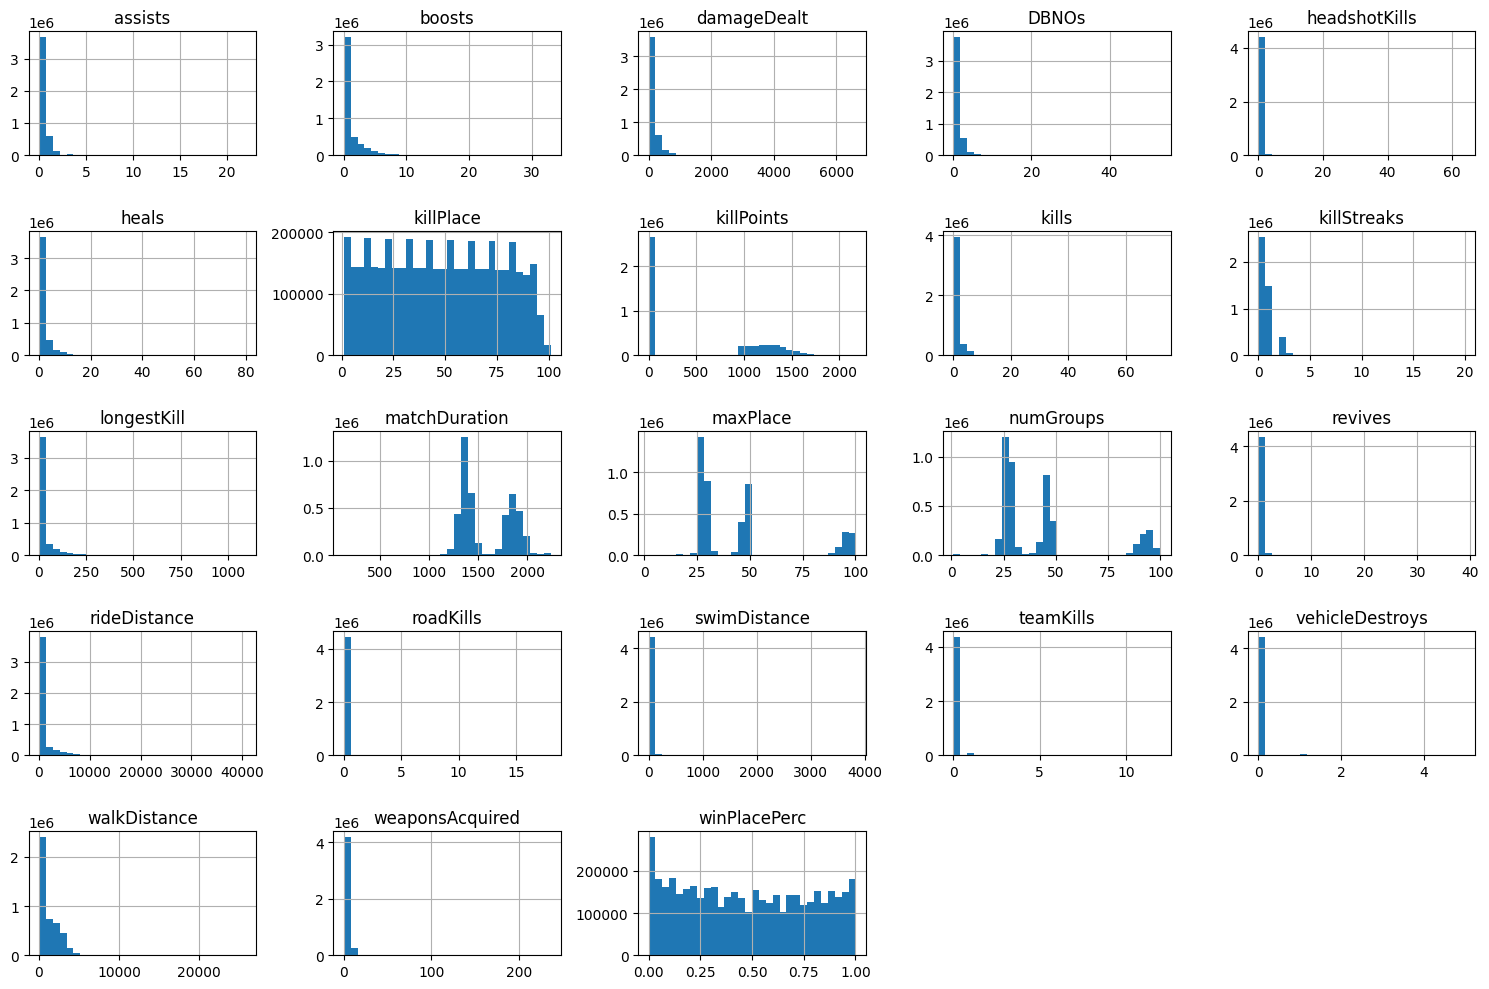

In [11]:
PUBG.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

#### Feature correlation analysis

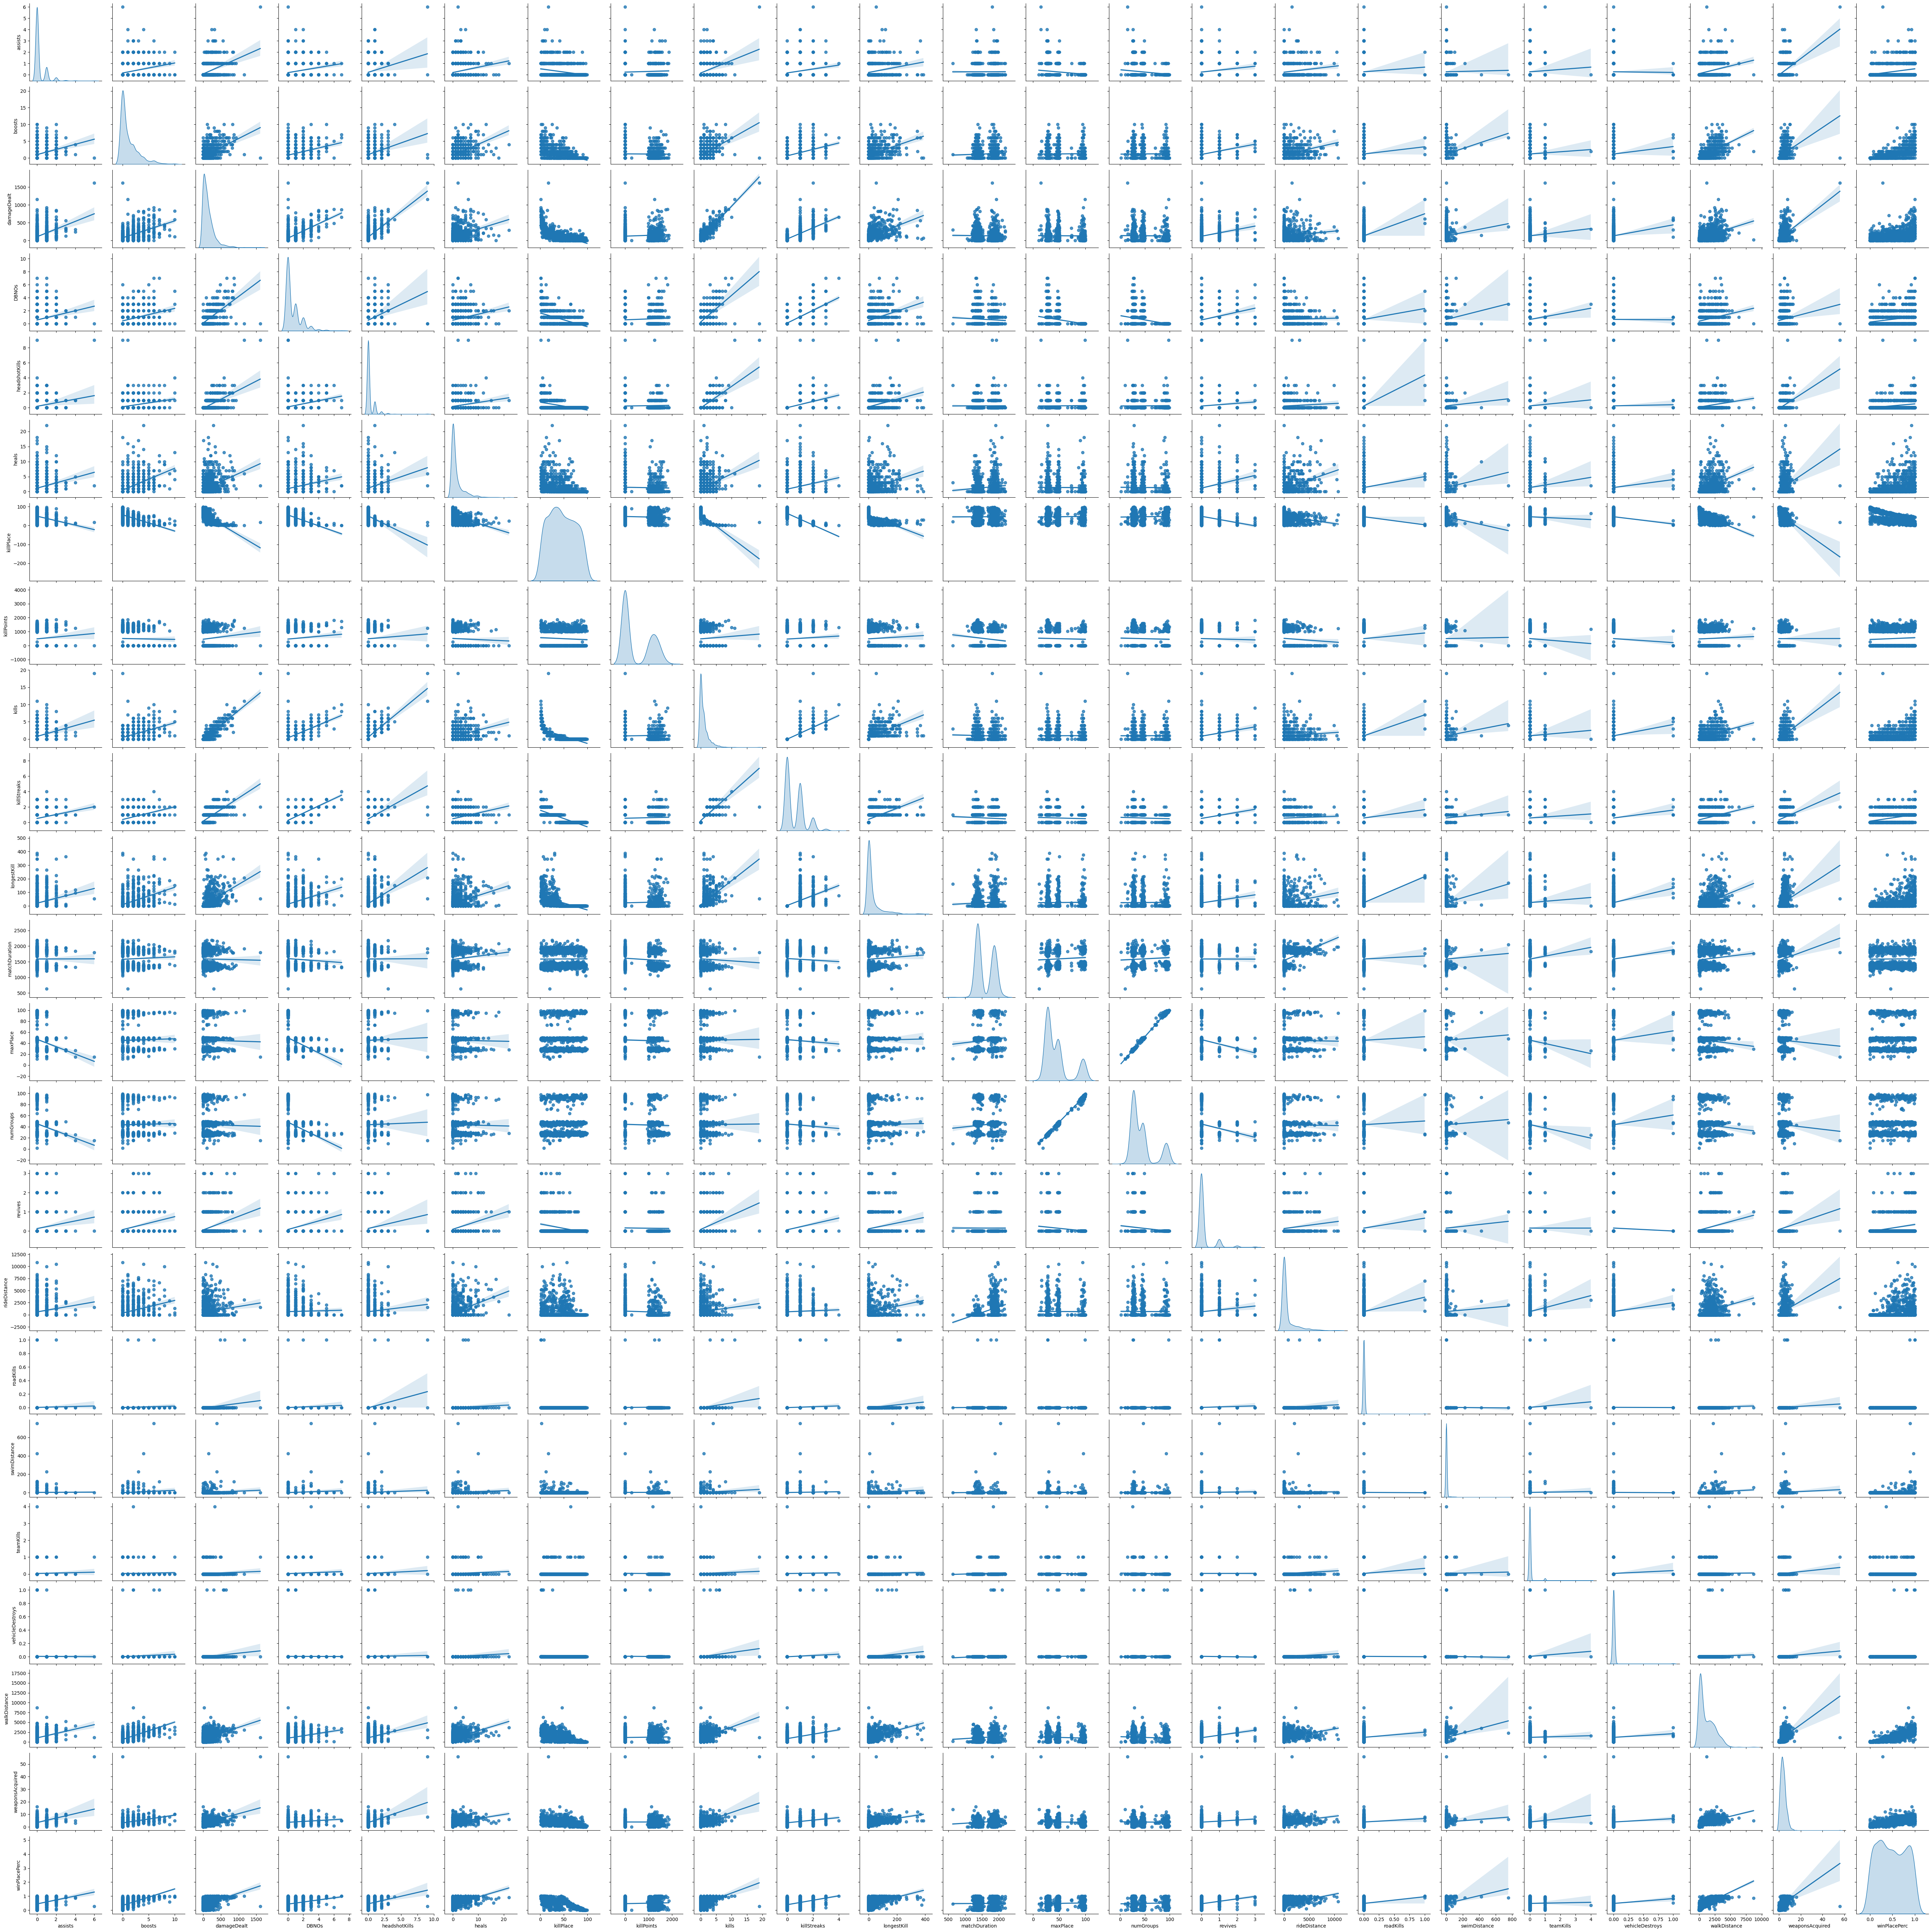

In [12]:
sns.pairplot(
    PUBG[
        ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills',
        'heals', 'killPlace', 'killPoints', 'kills', 'killStreaks',
        'longestKill', 'matchDuration', 'maxPlace', 'numGroups',
        'revives', 'rideDistance', 'roadKills', 'swimDistance',
        'teamKills', 'vehicleDestroys', 'walkDistance',
        'weaponsAcquired', 'winPlacePerc']
    ].sample(1000),
    kind='reg',
    diag_kind='kde'
)
plt.show()

In [13]:
feature = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'maxPlace', 'numGroups', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired']
corrs = []
for f in feature:
    corr = PUBG[[f, 'winPlacePerc']].corr()
    corrs.append(corr.loc['winPlacePerc', f])
corrs = pd.Series(corrs, index=feature).sort_values(ascending=False)
corrs

walkDistance       0.810888
boosts             0.634234
weaponsAcquired    0.583806
damageDealt        0.440507
heals              0.427857
kills              0.419916
longestKill        0.410154
killStreaks        0.377566
rideDistance       0.342915
assists            0.299441
DBNOs              0.279970
headshotKills      0.277722
revives            0.240881
swimDistance       0.149607
vehicleDestroys    0.073436
numGroups          0.039621
maxPlace           0.037377
roadKills          0.034544
teamKills          0.015943
killPoints         0.012908
matchDuration     -0.005171
killPlace         -0.719069
dtype: float64

In [14]:
features_to_drop = [
    'vehicleDestroys', 'maxPlace',
    'roadKills', 'teamKills', 'killPoints'
]

PUBG = PUBG.drop(columns=features_to_drop)

## 3. Feature Engineering

### 3.1 Feature Engineering

#### Feature creation

In [15]:
valid_match_types = ["solo", "duo", "squad", "solo-fpp", "duo-fpp", "squad-fpp"]
PUBG = PUBG[PUBG['matchType'].isin(valid_match_types)]

In [16]:
def encode_match_type(match_type):
    if 'solo' in match_type:
        return 'solo'
    elif 'duo' in match_type:
        return 'duo' 
    elif 'squad' in match_type:
        return 'squad'
    else:
        return 'other'

PUBG['matchType'] = PUBG['matchType'].apply(encode_match_type)

print(PUBG['matchType'].value_counts())

matchType
squad    2382712
duo      1310282
solo      718704
Name: count, dtype: int64


#### Feature encoding

In [17]:
PUBG = pd.get_dummies(PUBG, columns=['matchType'])

## 4. Model Construction and Training

### Train-test set splitting

In [18]:
# Separate features and target variable from training data
X = PUBG.drop(['winPlacePerc'], axis=1)
y = PUBG['winPlacePerc']

# Split the training data into training and validation sets (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Basic Model Establishment

In [19]:
pd.options.plotting.backend = 'plotly'

#### Linear Regression model

In [20]:
# Build the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict and evaluate the model on the validation set
linear_pred = linear_model.predict(X_test)
linear_mse = mean_squared_error(y_test, linear_pred)
print(f'Linear Regression MSE: {linear_mse}')

# Get feature coefficients
coefficients = pd.Series(linear_model.coef_, index=X_train.columns)
coefficients = coefficients.sort_values()

# Plot feature importance
fig = px.bar(
    x=coefficients.values,
    y=coefficients.index,
    title='Linear Regression Feature Coefficients',
    labels={'x': 'Coefficient', 'y': 'Feature'}
)
fig.update_layout(margin=dict(t=50))
fig.update_layout(width=730, height=550)
fig.show()

Linear Regression MSE: 0.014832906424999237


#### Ridge Regression model

In [21]:
# Build the Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Predict and evaluate the model on the validation set
ridge_pred = ridge_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
print(f'Ridge Regression MSE: {ridge_mse}')

# Get feature coefficients
ridge_coefficients = pd.Series(ridge_model.coef_, index=X_train.columns)
ridge_coefficients = ridge_coefficients.sort_values()

# Plot feature importance
fig = px.bar(
    x=ridge_coefficients.values,
    y=ridge_coefficients.index,
    title='Ridge Regression Feature Coefficients',
    labels={'x': 'Coefficient', 'y': 'Feature'}
)
fig.update_layout(margin=dict(t=50))
fig.update_layout(width=730, height=550)
fig.show()

Ridge Regression MSE: 0.01483291108161211


c:\Users\maoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.65289e-13): result may not be accurate.



#### Lasso Regression model

In [22]:
# Build the Lasso Regression model
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

# Predict and evaluate the model on the validation set
lasso_pred = lasso_model.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
print(f'Lasso Regression MSE: {lasso_mse}')

# Get feature coefficients
lasso_coefficients = pd.Series(lasso_model.coef_, index=X_train.columns)
lasso_coefficients = lasso_coefficients.sort_values()

# Plot feature importance
fig = px.bar(
    x=lasso_coefficients.values,
    y=lasso_coefficients.index,
    title='Lasso Regression Feature Coefficients',
    labels={'x': 'Coefficient', 'y': 'Feature'}
)
fig.update_layout(margin=dict(t=50))
fig.update_layout(width=730, height=550)
fig.show()

Lasso Regression MSE: 0.02004382759332657


### New Features Creation

In [23]:
# Total movement distance
PUBG['totalDistance'] = PUBG['rideDistance'] + PUBG['walkDistance'] + PUBG['swimDistance']

# Player performance score
PUBG['performanceScore'] = (PUBG['kills'] + 0.5 * PUBG['assists'] + 0.1 * PUBG['damageDealt']) / PUBG['matchDuration']

# Healing efficiency
PUBG['healsBoostRatio'] = PUBG['heals'] / (PUBG['boosts'] + 1)

# Aggressive behavior
PUBG['aggressiveness'] = PUBG['kills'] / (PUBG['damageDealt'] + 1)

# Defensive behavior
PUBG['relativeKillRank'] = 1 - (PUBG['killPlace'] - 1) / (PUBG['numGroups'] + 1)

# Kills per minute
PUBG['killsPerMinute'] = PUBG['kills'] / (PUBG['matchDuration'] / 60)

# Boosts used per minute
PUBG['boostsPerMinute'] = PUBG['boosts'] / (PUBG['matchDuration'] / 60)

# Kill efficiency
PUBG['kill_per_distance'] = PUBG['kills'] / (PUBG['totalDistance'] + 1)

# Damage efficiency
PUBG['damage_per_kill'] = PUBG['damageDealt'] / (PUBG['kills'] + 1)

# Survival efficiency
PUBG['survival_efficiency'] = PUBG['winPlacePerc'] / (PUBG['totalDistance'] + 1)

In [24]:
# Separate features and target variable from training data
X_added_feature = PUBG.drop(['winPlacePerc'], axis=1)
y_added_feature = PUBG['winPlacePerc']

# Split the training data into training and validation sets (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(X_added_feature, y_added_feature, test_size=0.2, random_state=42)

#### Random Forest Regression model

In [25]:
# Build the Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict and evaluate the model on the validation set
rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
print(f'Random Forest Regression MSE: {rf_mse}')

# Get feature importances
rf_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
rf_importances = rf_importances.sort_values()

# Plot feature importance
fig = px.bar(
    x=rf_importances.values,
    y=rf_importances.index,
    title='Random Forest Feature Importances',
    labels={'x': 'Coefficient', 'y': 'Feature'}
)
fig.update_layout(margin=dict(t=50))
fig.update_layout(width=730, height=550)
fig.show()

Random Forest Regression MSE: 5.2004774490754446e-05


### Gradient Boosting Decision Tree

#### LightGBM Regression model

In [26]:
# Initialize the LightGBM regressor
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,             # Number of boosting rounds
    device='gpu',                 # Use GPU for training
    gpu_platform_id=0,            # Specify the GPU platform ID
    gpu_device_id=0,              # Specify the GPU device ID
    random_state=42,              # Set a random seed for reproducibility
    verbose=1                     # Enable verbose output
)

# Train the model while monitoring performance on the validation set
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='mse',  # Use MSE as the evaluation metric
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(10)
    ]
)

# Predict and evaluate the model on the validation set
lgb_pred = lgb_model.predict(X_test)
lgb_mse = mean_squared_error(y_test, lgb_pred)
print(f'LightGBM Regression MSE: {lgb_mse}')

# Extract feature importance
lgb_importances = pd.Series(lgb_model.feature_importances_, index=X_train.columns)
lgb_importances = lgb_importances.sort_values()

# Plot feature importance
fig = px.bar(
    x=lgb_importances.values,
    y=lgb_importances.index,
    title='LightGBM Regressor Feature Coefficients',
    labels={'x': 'Coefficient', 'y': 'Feature'}
)
fig.update_layout(margin=dict(t=50))
fig.update_layout(width=730, height=550)
fig.show()

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.048120 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
[10]	valid_0's l2: 0.0181867
[20]	valid_0's l2: 0.00539291
[30]	valid_0's l2: 0.00244724
[40]	valid_0's l2: 0.00159232
[50]	valid_0's l2: 0.00122299
[60]	valid_0's l2: 0.00100897
[70]	valid_0's l2: 0.000854537
[80]	valid_0's l2: 0.000745565
[90]	valid_0's l2: 0.000665727
[100]	valid_0's l2: 0.0

In [27]:
def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'mse',
        'boosting_type': 'gbdt',
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'n_estimators': 500,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    model = lgb.LGBMRegressor(**param, random_state=42)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='mse',
        callbacks=[
            lgb.early_stopping(50)
        ]
    )
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)
    
# Create the optimizer and search for the best hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Output the best results
print("Best trial:")
print(f"  MSE: {study.best_value}")
print(f"  Params: {study.best_params}")

[I 2024-12-03 15:56:06,441] A new study created in memory with name: no-name-260ae6a1-2103-4289-85f9-1a57ec47b872


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.042325 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000190111


[I 2024-12-03 15:56:34,746] Trial 0 finished with value: 0.00019011065125338592 and parameters: {'learning_rate': 0.07421697338160015, 'max_depth': 7, 'num_leaves': 47, 'min_child_samples': 26, 'subsample': 0.6654944751250591, 'colsample_bytree': 0.5786950380230985, 'reg_alpha': 0.047596910955893836, 'reg_lambda': 3.784388377251406e-08}. Best is trial 0 with value: 0.00019011065125338592.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.041336 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-12-03 15:56:55,037] Trial 1 finished with value: 0.0001948257966938142 and parameters: {'learning_rate': 0.20598054442199293, 'max_depth': 5, 'num_leaves': 136, 'min_child_samples': 75, 'subsample': 0.7933397083329115, 'colsample_bytree': 0.6734730535135511, 'reg_alpha': 1.060663200040293e-07, 'reg_lambda': 3.118393455296071e-07}. Best is trial 0 with value: 0.00019011065125338592.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.041978 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000160198


[I 2024-12-03 15:57:16,668] Trial 2 finished with value: 0.0001601977981130942 and parameters: {'learning_rate': 0.18715837395662585, 'max_depth': 9, 'num_leaves': 35, 'min_child_samples': 18, 'subsample': 0.8975247884933257, 'colsample_bytree': 0.7100140880269641, 'reg_alpha': 0.02881538196550267, 'reg_lambda': 1.1159935335622998e-06}. Best is trial 2 with value: 0.0001601977981130942.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.044773 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000124922


[I 2024-12-03 15:57:40,081] Trial 3 finished with value: 0.00012492154598347103 and parameters: {'learning_rate': 0.26670416851221973, 'max_depth': 9, 'num_leaves': 87, 'min_child_samples': 63, 'subsample': 0.6840194642621495, 'colsample_bytree': 0.9469390328828988, 'reg_alpha': 1.0433380144911638e-08, 'reg_lambda': 0.002888307628405893}. Best is trial 3 with value: 0.00012492154598347103.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.043758 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.00075048


[I 2024-12-03 15:58:02,033] Trial 4 finished with value: 0.0007504799969081636 and parameters: {'learning_rate': 0.02144020043799081, 'max_depth': 7, 'num_leaves': 25, 'min_child_samples': 87, 'subsample': 0.8701145240257274, 'colsample_bytree': 0.8143573195426919, 'reg_alpha': 4.557306990740049e-05, 'reg_lambda': 0.0028751413256214134}. Best is trial 3 with value: 0.00012492154598347103.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.044424 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.00018267


[I 2024-12-03 15:58:34,098] Trial 5 finished with value: 0.00018266972665193488 and parameters: {'learning_rate': 0.0624709769049677, 'max_depth': 8, 'num_leaves': 61, 'min_child_samples': 10, 'subsample': 0.799118043109919, 'colsample_bytree': 0.5731852519558069, 'reg_alpha': 1.4934597607789653, 'reg_lambda': 0.011495350708116898}. Best is trial 3 with value: 0.00012492154598347103.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.041423 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-12-03 15:58:47,419] Trial 6 finished with value: 0.0008019056560751108 and parameters: {'learning_rate': 0.10539692010942739, 'max_depth': 3, 'num_leaves': 32, 'min_child_samples': 64, 'subsample': 0.6009500260064153, 'colsample_bytree': 0.7401886110629632, 'reg_alpha': 0.0008249484095634581, 'reg_lambda': 0.10629686193803597}. Best is trial 3 with value: 0.00012492154598347103.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.041068 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000137667


[I 2024-12-03 15:59:13,725] Trial 7 finished with value: 0.0001376669265235826 and parameters: {'learning_rate': 0.1749616607577156, 'max_depth': 12, 'num_leaves': 77, 'min_child_samples': 41, 'subsample': 0.7762717525575127, 'colsample_bytree': 0.8031220934787453, 'reg_alpha': 1.8850364460060433e-05, 'reg_lambda': 5.870913625674091e-05}. Best is trial 3 with value: 0.00012492154598347103.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.043924 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000133616


[I 2024-12-03 15:59:35,336] Trial 8 finished with value: 0.00013361623139672955 and parameters: {'learning_rate': 0.12300991475841129, 'max_depth': 12, 'num_leaves': 59, 'min_child_samples': 7, 'subsample': 0.7121883851869752, 'colsample_bytree': 0.9805428317856195, 'reg_alpha': 1.3757216371871774e-07, 'reg_lambda': 0.0030032636549792153}. Best is trial 3 with value: 0.00012492154598347103.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.044943 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000143101


[I 2024-12-03 15:59:55,834] Trial 9 finished with value: 0.00014310107326705906 and parameters: {'learning_rate': 0.14464375064512616, 'max_depth': 11, 'num_leaves': 43, 'min_child_samples': 33, 'subsample': 0.8037290034127219, 'colsample_bytree': 0.903860102177655, 'reg_alpha': 0.0003463131524309894, 'reg_lambda': 1.2996157456668623e-06}. Best is trial 3 with value: 0.00012492154598347103.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.041511 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000125838


[I 2024-12-03 16:00:23,088] Trial 10 finished with value: 0.00012583827233504042 and parameters: {'learning_rate': 0.28599220623500027, 'max_depth': 10, 'num_leaves': 116, 'min_child_samples': 97, 'subsample': 0.5043165351021246, 'colsample_bytree': 0.9448137926093747, 'reg_alpha': 1.0799118610261668e-08, 'reg_lambda': 4.4869353224303365}. Best is trial 3 with value: 0.00012492154598347103.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.042744 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000130338


[I 2024-12-03 16:00:48,750] Trial 11 finished with value: 0.0001303376371599546 and parameters: {'learning_rate': 0.29955043303407247, 'max_depth': 10, 'num_leaves': 115, 'min_child_samples': 98, 'subsample': 0.504310683789411, 'colsample_bytree': 0.9960537573771183, 'reg_alpha': 1.1639603173156505e-08, 'reg_lambda': 6.396696243382545}. Best is trial 3 with value: 0.00012492154598347103.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.043199 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000121652


[I 2024-12-03 16:01:14,517] Trial 12 finished with value: 0.00012165224254427307 and parameters: {'learning_rate': 0.2968218721627303, 'max_depth': 9, 'num_leaves': 104, 'min_child_samples': 52, 'subsample': 0.9968369395334027, 'colsample_bytree': 0.9029178356679892, 'reg_alpha': 1.102598476271231e-06, 'reg_lambda': 6.275943506512438}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.043253 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000141855


[I 2024-12-03 16:01:41,620] Trial 13 finished with value: 0.00014185523558605222 and parameters: {'learning_rate': 0.2483936023677614, 'max_depth': 8, 'num_leaves': 98, 'min_child_samples': 49, 'subsample': 0.9977856895629462, 'colsample_bytree': 0.8723368372238786, 'reg_alpha': 1.6364600414358795e-06, 'reg_lambda': 8.094327406423066e-05}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.044734 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-12-03 16:02:03,859] Trial 14 finished with value: 0.00015296844640337617 and parameters: {'learning_rate': 0.23601202302366986, 'max_depth': 6, 'num_leaves': 91, 'min_child_samples': 61, 'subsample': 0.9690930143460346, 'colsample_bytree': 0.8624967645481608, 'reg_alpha': 2.753329768778387e-06, 'reg_lambda': 0.23638604279103026}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.041015 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-12-03 16:02:34,547] Trial 15 finished with value: 0.00012586170261255465 and parameters: {'learning_rate': 0.2421527506045935, 'max_depth': 9, 'num_leaves': 148, 'min_child_samples': 72, 'subsample': 0.6372501814703155, 'colsample_bytree': 0.9242181393577442, 'reg_alpha': 3.0583631820071534e-07, 'reg_lambda': 0.4781142212824925}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.040156 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-12-03 16:02:52,556] Trial 16 finished with value: 0.00018918269223903436 and parameters: {'learning_rate': 0.26503695833244745, 'max_depth': 5, 'num_leaves': 110, 'min_child_samples': 51, 'subsample': 0.8933325903915238, 'colsample_bytree': 0.8089036385492279, 'reg_alpha': 1.815636946821679e-06, 'reg_lambda': 0.000359241278203246}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.043829 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.00013533


[I 2024-12-03 16:03:20,711] Trial 17 finished with value: 0.00013533006384576455 and parameters: {'learning_rate': 0.21230601351583367, 'max_depth': 10, 'num_leaves': 79, 'min_child_samples': 62, 'subsample': 0.7148929952102594, 'colsample_bytree': 0.6561200227598037, 'reg_alpha': 2.4278034117120252e-05, 'reg_lambda': 0.0337666596129893}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.040443 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000139844


[I 2024-12-03 16:03:50,596] Trial 18 finished with value: 0.00013984383403488335 and parameters: {'learning_rate': 0.27483453493149756, 'max_depth': 9, 'num_leaves': 128, 'min_child_samples': 79, 'subsample': 0.6056159760371111, 'colsample_bytree': 0.8471827995321171, 'reg_alpha': 9.979874793193826e-08, 'reg_lambda': 1.5648903243660723}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.040626 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000129496


[I 2024-12-03 16:04:15,347] Trial 19 finished with value: 0.00012949569572239 and parameters: {'learning_rate': 0.22671284793843072, 'max_depth': 11, 'num_leaves': 102, 'min_child_samples': 42, 'subsample': 0.8485522680668567, 'colsample_bytree': 0.9485833540928076, 'reg_alpha': 0.00480364334432465, 'reg_lambda': 0.000576632078424333}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.042251 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-12-03 16:04:28,378] Trial 20 finished with value: 0.0003910148693347102 and parameters: {'learning_rate': 0.2660508182080347, 'max_depth': 3, 'num_leaves': 74, 'min_child_samples': 55, 'subsample': 0.717808805105749, 'colsample_bytree': 0.7721330463019139, 'reg_alpha': 1.0427628786189821e-08, 'reg_lambda': 0.022707475671912888}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.043948 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000129201


[I 2024-12-03 16:04:54,153] Trial 21 finished with value: 0.00012920067173084493 and parameters: {'learning_rate': 0.29884398626565395, 'max_depth': 10, 'num_leaves': 121, 'min_child_samples': 99, 'subsample': 0.5064784754038263, 'colsample_bytree': 0.9541228446012483, 'reg_alpha': 1.5835322068997923e-08, 'reg_lambda': 6.897195914951305}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.044249 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000124422


[I 2024-12-03 16:05:20,118] Trial 22 finished with value: 0.00012442244928282252 and parameters: {'learning_rate': 0.28173650334374156, 'max_depth': 9, 'num_leaves': 105, 'min_child_samples': 89, 'subsample': 0.566224604605386, 'colsample_bytree': 0.903792993905141, 'reg_alpha': 5.8090006241039e-07, 'reg_lambda': 0.9742120641872954}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.042786 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-12-03 16:05:45,790] Trial 23 finished with value: 0.0001243883383788759 and parameters: {'learning_rate': 0.26052821339888804, 'max_depth': 8, 'num_leaves': 91, 'min_child_samples': 86, 'subsample': 0.5480463684332029, 'colsample_bytree': 0.899354163810201, 'reg_alpha': 6.420190607282451e-07, 'reg_lambda': 0.6987543188912542}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.043654 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-12-03 16:06:12,964] Trial 24 finished with value: 0.00012600214041270566 and parameters: {'learning_rate': 0.2562878016438442, 'max_depth': 8, 'num_leaves': 103, 'min_child_samples': 85, 'subsample': 0.5546568243811624, 'colsample_bytree': 0.8955411953168243, 'reg_alpha': 5.954846962325208e-06, 'reg_lambda': 1.041126435165724}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.041203 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-12-03 16:06:35,223] Trial 25 finished with value: 0.00015673773898968837 and parameters: {'learning_rate': 0.21785568381152895, 'max_depth': 6, 'num_leaves': 93, 'min_child_samples': 87, 'subsample': 0.5625488167754389, 'colsample_bytree': 0.8433092055476609, 'reg_alpha': 4.2600875492179787e-07, 'reg_lambda': 0.22181796500762702}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.041618 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-12-03 16:07:07,977] Trial 26 finished with value: 0.00017695574115263207 and parameters: {'learning_rate': 0.2852691945080737, 'max_depth': 7, 'num_leaves': 131, 'min_child_samples': 68, 'subsample': 0.5676236787233434, 'colsample_bytree': 0.5130833209990304, 'reg_alpha': 9.733713413358566e-05, 'reg_lambda': 1.641370772987008}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.042443 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000136386


[I 2024-12-03 16:07:32,069] Trial 27 finished with value: 0.00013638633027702714 and parameters: {'learning_rate': 0.17407606847386917, 'max_depth': 8, 'num_leaves': 67, 'min_child_samples': 91, 'subsample': 0.9582363601777131, 'colsample_bytree': 0.8933528335576264, 'reg_alpha': 5.531022205217238e-07, 'reg_lambda': 0.07741982555537605}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.043645 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000139218


[I 2024-12-03 16:08:00,299] Trial 28 finished with value: 0.00013921785083239417 and parameters: {'learning_rate': 0.29708850280468907, 'max_depth': 11, 'num_leaves': 107, 'min_child_samples': 80, 'subsample': 0.6330484610638233, 'colsample_bytree': 0.7640099142764695, 'reg_alpha': 5.83549953988743e-06, 'reg_lambda': 9.953728411902482}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.042325 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-12-03 16:08:26,243] Trial 29 finished with value: 0.00013573675586417406 and parameters: {'learning_rate': 0.19526819569868933, 'max_depth': 7, 'num_leaves': 84, 'min_child_samples': 29, 'subsample': 0.6694037876563268, 'colsample_bytree': 0.9085508836486532, 'reg_alpha': 1.35622115128497, 'reg_lambda': 0.47710896498760824}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.044333 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-12-03 16:08:48,309] Trial 30 finished with value: 0.0001565477477824267 and parameters: {'learning_rate': 0.24359886788284255, 'max_depth': 6, 'num_leaves': 123, 'min_child_samples': 45, 'subsample': 0.5409150062403724, 'colsample_bytree': 0.8312850872389286, 'reg_alpha': 4.7618018695823004e-08, 'reg_lambda': 2.5389458656304213e-08}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.042076 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000128744


[I 2024-12-03 16:09:11,588] Trial 31 finished with value: 0.00012874413657369956 and parameters: {'learning_rate': 0.2759101298737992, 'max_depth': 9, 'num_leaves': 92, 'min_child_samples': 58, 'subsample': 0.6720123262970524, 'colsample_bytree': 0.9718298280026049, 'reg_alpha': 5.765985987650301e-07, 'reg_lambda': 0.0054092779583609476}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.042617 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000132233


[I 2024-12-03 16:09:34,347] Trial 32 finished with value: 0.00013223336701359843 and parameters: {'learning_rate': 0.2604923521237367, 'max_depth': 9, 'num_leaves': 85, 'min_child_samples': 76, 'subsample': 0.6001482086770459, 'colsample_bytree': 0.9356199773052936, 'reg_alpha': 5.0525362034183e-08, 'reg_lambda': 8.23080730728866e-06}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.042560 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's l2: 0.000143401


[I 2024-12-03 16:10:00,438] Trial 33 finished with value: 0.00014340107156340392 and parameters: {'learning_rate': 0.27956497163817223, 'max_depth': 9, 'num_leaves': 98, 'min_child_samples': 70, 'subsample': 0.6466182892135504, 'colsample_bytree': 0.866542007801101, 'reg_alpha': 5.3729829129218146e-08, 'reg_lambda': 1.5524926156847805}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.042225 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000151553


[I 2024-12-03 16:10:22,901] Trial 34 finished with value: 0.00015155342597038114 and parameters: {'learning_rate': 0.22826365518972508, 'max_depth': 8, 'num_leaves': 69, 'min_child_samples': 83, 'subsample': 0.6891815042902967, 'colsample_bytree': 0.9997832971152298, 'reg_alpha': 5.2955855137986445e-06, 'reg_lambda': 0.1071617952095103}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.040947 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000123772


[I 2024-12-03 16:10:58,919] Trial 35 finished with value: 0.00012377192710208803 and parameters: {'learning_rate': 0.20132690504680345, 'max_depth': 10, 'num_leaves': 140, 'min_child_samples': 36, 'subsample': 0.753750846631893, 'colsample_bytree': 0.66248884540396, 'reg_alpha': 8.592536257722696e-05, 'reg_lambda': 0.0012575905789993602}. Best is trial 12 with value: 0.00012165224254427307.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.042271 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.00012078


[I 2024-12-03 16:11:36,264] Trial 36 finished with value: 0.00012077963857665233 and parameters: {'learning_rate': 0.15009653777915577, 'max_depth': 10, 'num_leaves': 143, 'min_child_samples': 21, 'subsample': 0.8392666079025112, 'colsample_bytree': 0.6648412061673137, 'reg_alpha': 0.0020934776151556914, 'reg_lambda': 4.626161746331705e-07}. Best is trial 36 with value: 0.00012077963857665233.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.042463 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000121787


[I 2024-12-03 16:12:15,082] Trial 37 finished with value: 0.00012178735122888214 and parameters: {'learning_rate': 0.14855822729316795, 'max_depth': 11, 'num_leaves': 143, 'min_child_samples': 19, 'subsample': 0.8356095448801169, 'colsample_bytree': 0.6590368481850248, 'reg_alpha': 0.004799799511405365, 'reg_lambda': 8.786984938889588e-08}. Best is trial 36 with value: 0.00012077963857665233.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.041773 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000122934


[I 2024-12-03 16:12:53,079] Trial 38 finished with value: 0.00012293405863607928 and parameters: {'learning_rate': 0.15299853970234786, 'max_depth': 11, 'num_leaves': 144, 'min_child_samples': 17, 'subsample': 0.8341113709483079, 'colsample_bytree': 0.6613416591840074, 'reg_alpha': 0.06190307928194519, 'reg_lambda': 9.780168694615923e-08}. Best is trial 36 with value: 0.00012077963857665233.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.044648 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000120292


[I 2024-12-03 16:13:32,975] Trial 39 finished with value: 0.00012029240479856891 and parameters: {'learning_rate': 0.14206072015261345, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 19, 'subsample': 0.8435730804233278, 'colsample_bytree': 0.6182044246884588, 'reg_alpha': 0.0962116849142692, 'reg_lambda': 9.936953686691456e-08}. Best is trial 39 with value: 0.00012029240479856891.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.042601 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000115386


[I 2024-12-03 16:14:16,097] Trial 40 finished with value: 0.00011538625781185605 and parameters: {'learning_rate': 0.10199279718010087, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 17, 'subsample': 0.9026507133378047, 'colsample_bytree': 0.60930558563234, 'reg_alpha': 0.15443809041822773, 'reg_lambda': 5.181661149386898e-07}. Best is trial 40 with value: 0.00011538625781185605.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.044207 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000113573


[I 2024-12-03 16:14:59,742] Trial 41 finished with value: 0.00011357255034370925 and parameters: {'learning_rate': 0.09335751486712968, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 20, 'subsample': 0.9330586959371523, 'colsample_bytree': 0.6209109413644812, 'reg_alpha': 0.19801086520478534, 'reg_lambda': 5.13556293491743e-07}. Best is trial 41 with value: 0.00011357255034370925.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.047076 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000113025


[I 2024-12-03 16:15:43,175] Trial 42 finished with value: 0.00011302538454359321 and parameters: {'learning_rate': 0.09369127992090179, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 21, 'subsample': 0.9273551741587066, 'colsample_bytree': 0.617700465621102, 'reg_alpha': 0.2901827856560131, 'reg_lambda': 8.232801339056353e-07}. Best is trial 42 with value: 0.00011302538454359321.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.044344 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000114816


[I 2024-12-03 16:16:27,677] Trial 43 finished with value: 0.0001148156754913897 and parameters: {'learning_rate': 0.09015205800601539, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 23, 'subsample': 0.9249578301767681, 'colsample_bytree': 0.6138543249303331, 'reg_alpha': 0.25439194857625747, 'reg_lambda': 9.549182724062361e-07}. Best is trial 42 with value: 0.00011302538454359321.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.043879 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000114747


[I 2024-12-03 16:17:13,081] Trial 44 finished with value: 0.00011474724817467123 and parameters: {'learning_rate': 0.07773005614033279, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 11, 'subsample': 0.9283569787346793, 'colsample_bytree': 0.6141394091048518, 'reg_alpha': 0.2604118154568937, 'reg_lambda': 3.873918421377129e-06}. Best is trial 42 with value: 0.00011302538454359321.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.043291 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.00012266


[I 2024-12-03 16:17:57,701] Trial 45 finished with value: 0.0001226604868312154 and parameters: {'learning_rate': 0.07000075951724996, 'max_depth': 12, 'num_leaves': 134, 'min_child_samples': 12, 'subsample': 0.9294000522923935, 'colsample_bytree': 0.5690684402000856, 'reg_alpha': 0.4461331742478328, 'reg_lambda': 3.923781945778222e-06}. Best is trial 42 with value: 0.00011302538454359321.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.043550 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000116709


[I 2024-12-03 16:18:41,350] Trial 46 finished with value: 0.00011670929461466567 and parameters: {'learning_rate': 0.08848901842065623, 'max_depth': 12, 'num_leaves': 137, 'min_child_samples': 25, 'subsample': 0.9189358460311776, 'colsample_bytree': 0.6121510257429831, 'reg_alpha': 0.35164108184227794, 'reg_lambda': 1.1965859636927888e-08}. Best is trial 42 with value: 0.00011302538454359321.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.042058 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.00013203


[I 2024-12-03 16:19:28,333] Trial 47 finished with value: 0.00013203016484442513 and parameters: {'learning_rate': 0.04571478066739932, 'max_depth': 12, 'num_leaves': 149, 'min_child_samples': 5, 'subsample': 0.8840721778656494, 'colsample_bytree': 0.7047278920588615, 'reg_alpha': 4.739926034296134, 'reg_lambda': 1.5673592368757925e-05}. Best is trial 42 with value: 0.00011302538454359321.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.041357 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000132303


[I 2024-12-03 16:20:10,279] Trial 48 finished with value: 0.0001323025652963727 and parameters: {'learning_rate': 0.10591909078329437, 'max_depth': 12, 'num_leaves': 126, 'min_child_samples': 15, 'subsample': 0.9207898882042134, 'colsample_bytree': 0.5429754041054333, 'reg_alpha': 0.01961739755820321, 'reg_lambda': 1.3452279487641919e-06}. Best is trial 42 with value: 0.00011302538454359321.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (80.78 MB) transferred to GPU in 0.041288 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.000137988


[I 2024-12-03 16:20:55,126] Trial 49 finished with value: 0.0001379876102352837 and parameters: {'learning_rate': 0.045853995111989315, 'max_depth': 11, 'num_leaves': 136, 'min_child_samples': 10, 'subsample': 0.9455512523758126, 'colsample_bytree': 0.5883407401935293, 'reg_alpha': 0.1652073064987654, 'reg_lambda': 2.943013873705365e-07}. Best is trial 42 with value: 0.00011302538454359321.


Best trial:
  MSE: 0.00011302538454359321
  Params: {'learning_rate': 0.09369127992090179, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 21, 'subsample': 0.9273551741587066, 'colsample_bytree': 0.617700465621102, 'reg_alpha': 0.2901827856560131, 'reg_lambda': 8.232801339056353e-07}


In [30]:
# Train the model with the best parameters
best_params = study.best_params
final_model = lgb.LGBMRegressor(**best_params, random_state=42)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='mse',
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(10)
    ]
)
    
# Predict and evaluate the final model
final_preds = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_preds)
print(f"Final MSE: {final_mse}")
    
importances = pd.Series(final_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values()
    
fig = px.bar(
    x=importances.values,
    y=importances.index,
    title='LightGBM Feature Importances (Optimized)',
    labels={'x': 'Importance', 'y': 'Feature'}
)
fig.update_layout(margin=dict(t=50), width=730, height=550)
fig.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 3529358, number of used features: 30
[LightGBM] [Info] Start training from score 0.472625
Training until validation scores don't improve for 50 rounds
[10]	valid_0's l2: 0.0165942
[20]	valid_0's l2: 0.00343256
[30]	valid_0's l2: 0.00142158
[40]	valid_0's l2: 0.000753414
[50]	valid_0's l2: 0.000571388
[60]	valid_0's l2: 0.000456591
[70]	valid_0's l2: 0.000391599
[80]	valid_0's l2: 0.000349492
[90]	valid_0's l2: 0.000302281
[100]	valid_0's l2: 0.000277829
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.000277829
Final MSE: 0.00027782948129111205
